In [1]:
import features as feat
import clusterize as clust

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.neighbors import kneighbors_graph

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FEATURES_PATH = "/home/guilherme/Mestrado/action_segmentation_app/data/RoadAccidents010_x264.mp4"

In [2]:
features = feat.Features(FEATURES_PATH).read()
features = scale(features)
features.shape, features.std(), features.mean(), features.min(), features.max()

/home/guilherme/.virtualenvs/action_segmentation_env/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/guilherme/.virtualenvs/action_segmentation_env/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


((512, 2304), 1.0, -7.709281e-09, -3.710277, 5.567751)

In [3]:
clusterizer = clust.KMeansClusterStrategy(k=6)
labels = clusterizer.clusterize(features)

In [5]:
gm_clusterizer = clust.GaussianMixtureClusterStrategy(n=6)
gm_labels = gm_clusterizer.clusterize(features)

In [6]:
sc_clusterizer = clust.SpectralClusterStrategy(n=6, affinity="nearest_neighbors")
sc_labels = sc_clusterizer.clusterize(features)

/home/guilherme/.virtualenvs/action_segmentation_env/lib/python3.6/site-packages/scikit_learn-0.23.2-py3.6-linux-x86_64.egg/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [7]:
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

tsne = TSNE(n_components=2, perplexity=50)
vis_features = tsne.fit_transform(reduced_features)

In [8]:
sum(pca.explained_variance_ratio_), tsne.kl_divergence_

(0.999999675550592, 0.008093700744211674)

In [9]:
vis_feat_df = pd.DataFrame(vis_features, columns=["x", "y"])
vis_feat_df["labels"] = labels
vis_feat_df["gm_labels"] = gm_labels
vis_feat_df["sc_labels"] = sc_labels

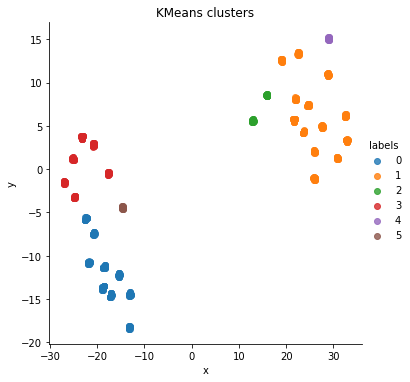

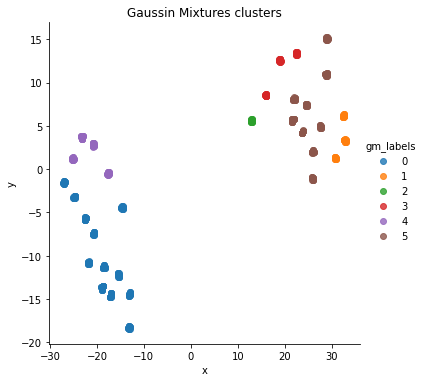

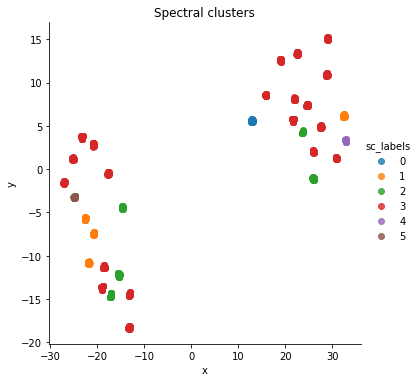

In [10]:
sns.lmplot(data=vis_feat_df, x='x', y='y', hue='labels', 
           fit_reg=False, legend=True, legend_out=True).set(title="KMeans clusters")

sns.lmplot(data=vis_feat_df, x='x', y='y', hue='gm_labels', 
           fit_reg=False, legend=True, legend_out=True).set(title="Gaussin Mixtures clusters")

sns.lmplot(data=vis_feat_df, x='x', y='y', hue='sc_labels', 
           fit_reg=False, legend=True, legend_out=True).set(title="Spectral clusters")

In [12]:
def get_segments(data: np.ndarray):
    """ Get continuous time intervals (segments) from a video
    
    args:
    data - label of each segment
    labels - the unique labels
    
    return:
    segs - dict of list of tuples, where each key is a label and tuple is a continuous segment 
    """
    segs = []
    for label in np.unique(data):
        idxs = np.where(data == label)[0]
        curr = idxs[0]
        last = None
        step = 0
        for idx in idxs:
            if idx != curr + step:
                segs.append({label: (curr, last)})
                curr = idx
                step = 1
                last = None
            else:
                last = idx
                step += 1

        segs.append({label: (curr, idx)})
    segs.sort(key=lambda value: list(value.values())[0])
    return segs

In [13]:
get_segments(gm_labels)

[{1: (0, 47)},
 {5: (48, 191)},
 {3: (192, 239)},
 {2: (240, 255)},
 {0: (256, 271)},
 {4: (272, 335)},
 {0: (336, 511)}]

In [4]:
from video import Video

In [6]:
v = Video(FEATURES_PATH)
paths = v.clusters_to_videos(labels)

save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save
save


FileNotFoundError: [Errno 2] No such file or directory: 'home/guilherme/Mestrado/action_segmentation_app/data/RoadAccidents010_x264.mp4_segments/temp_1_0_175_RoadAccidents010_x264.mp4'

In [54]:
get_segments(labels)

[{1: (0, 175)},
 {4: (176, 191)},
 {1: (192, 223)},
 {2: (224, 255)},
 {5: (256, 271)},
 {3: (272, 367)},
 {0: (368, 511)}]

In [26]:
get_segments(sc_labels, np.unique(sc_labels))

{0: [(240, 255)],
 1: [(0, 15), (368, 415)],
 2: [(48, 63), (144, 159), (256, 271), (448, 479)],
 3: [(32, 47), (64, 143), (160, 239), (272, 351), (416, 447), (480, 511)],
 4: [(16, 31)],
 5: [(352, 367)]}